## https://towardsdatascience.com/lstm-autoencoder-for-extreme-rare-event-classification-in-keras-ce209a224cfb

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
from pylab import rcParams

import tensorflow as tf
from keras import optimizers, Sequential
from keras.models import Model
from keras.utils import plot_model
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from keras.callbacks import ModelCheckpoint, TensorBoard

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(123)
from sklearn.model_selection import train_test_split

SEED = 123 #used to help randomly select the data points
DATA_SPLIT_PCT = 0.2

rcParams['figure.figsize'] = 8, 6
LABELS = ["Normal","Break"]

Using TensorFlow backend.


In [2]:
df = pd.read_csv("processminer-rare-event-mts - data.csv") 
df.head()  # visualize the data.

,time,y,x1,x2,x3,x4,x5,x6,x7,x8,...,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61
0,5/1/99 0:00,0,0.376665,-4.596435,-4.095756,13.497687,-0.118830,-20.669883,0.000732,-0.061114,...,10.091721,0.053279,-4.936434,-24.590146,18.515436,3.473400,0.033444,0.953219,0.006076,0
1,5/1/99 0:02,0,0.475720,-4.542502,-4.018359,16.230659,-0.128733,-18.758079,0.000732,-0.061114,...,10.095871,0.062801,-4.937179,-32.413266,22.760065,2.682933,0.033536,1.090502,0.006083,0
2,5/1/99 0:04,0,0.363848,-4.681394,-4.353147,14.127998,-0.138636,-17.836632,0.010803,-0.061114,...,10.100265,0.072322,-4.937924,-34.183774,27.004663,3.537487,0.033629,1.840540,0.006090,0
3,5/1/99 0:06,0,0.301590,-4.758934,-4.023612,13.161567,-0.148142,-18.517601,0.002075,-0.061114,...,10.104660,0.081600,-4.938669,-35.954281,21.672449,3.986095,0.033721,2.554880,0.006097,0
4,5/1/99 0:08,0,0.265578,-4.749928,-4.333150,15.267340,-0.155314,-17.505913,0.000732,-0.061114,...,10.109054,0.091121,-4.939414,-37.724789,21.907251,3.601573,0.033777,1.410494,0.006105,0


In [3]:
input_y = df['y']
input_y.head()

0    0
1    0
2    0
3    0
4    0
Name: y, dtype: int64

In [4]:
sign = lambda x: (1, -1)[x < 0]

def curve_shift(df, shift_by):
    '''
    This function will shift the binary labels in a dataframe.
    The curve shift will be with respect to the 1s. 
    For example, if shift is -2, the following process
    will happen: if row n is labeled as 1, then
    - Make row (n+shift_by):(n+shift_by-1) = 1.
    - Remove row n.
    i.e. the labels will be shifted up to 2 rows up.
    
    Inputs:
    df       A pandas dataframe with a binary labeled column. 
             This labeled column should be named as 'y'.
    shift_by An integer denoting the number of rows to shift.
    
    Output
    df       A dataframe with the binary labels shifted by shift.
    '''

    vector = df['y'].copy()
    for s in range(abs(shift_by)):
        tmp = vector.shift(sign(shift_by))
        tmp = tmp.fillna(0)
        vector += tmp
    labelcol = 'y'
    # Add vector to the df
    df.insert(loc=0, column=labelcol+'tmp', value=vector)
    # Remove the rows with labelcol == 1.
    df = df.drop(df[df[labelcol] == 1].index)
    # Drop labelcol and rename the tmp col as labelcol
    df = df.drop(labelcol, axis=1)
    df = df.rename(columns={labelcol+'tmp': labelcol})
    # Make the labelcol binary
    df.loc[df[labelcol] > 0, labelcol] = 1

    return df

In [5]:
print('Before shifting')  # Positive labeled rows before shifting.
one_indexes = df.index[df['y'] == 1]
print (one_indexes)
display(df.iloc[(np.where(np.array(input_y) == 1)[0][0]-5):(np.where(np.array(input_y) == 1)[0][0]+1), ])

Before shifting
Int64Index([  259,   776,   835,  1036,  1263,  1301,  1339,  1344,  1719,
             1750,
            ...
            16923, 17033, 17182, 17205, 17293, 17476, 17605, 17866, 17893,
            18009],
           dtype='int64', length=124)


,time,y,x1,x2,x3,x4,x5,x6,x7,x8,...,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61
254,5/1/99 8:28,0,0.975947,-3.913736,-1.304682,0.561987,0.004034,14.630532,0.000732,-0.051043,...,11.257736,-0.752385,-5.015081,-61.783749,71.917352,3.473400,0.031310,2.981432,0.007743,0
255,5/1/99 8:30,0,0.997107,-3.865720,-1.133779,0.377295,-0.219126,14.666420,0.000732,-0.061114,...,11.262375,-0.752385,-5.015176,-70.151791,73.876977,3.473400,0.030776,2.563593,0.007727,0
256,5/1/99 8:32,0,1.016235,-4.058394,-1.097158,2.327307,-0.442286,14.702309,0.000732,-0.061114,...,11.267013,-0.752385,-5.015270,-60.884701,72.188928,4.114269,0.031186,2.982454,0.007711,0
257,5/1/99 8:34,0,1.005602,-3.876199,-1.074373,0.844397,-0.553050,14.738228,0.000732,-0.061114,...,11.271652,-0.752385,-5.015364,-69.553891,70.500879,4.050182,0.031596,3.746714,0.007695,0
258,5/1/99 8:36,0,0.933933,-3.868467,-1.249954,2.875311,-0.500941,15.643990,0.000732,-0.061114,...,11.276291,-0.752385,-5.015458,-75.298153,68.812829,3.473400,0.032007,4.712130,0.007679,0
259,5/1/99 8:38,1,0.892311,-13.332664,-10.006578,2.855933,-0.448832,15.986336,0.000732,-0.061114,...,11.280929,-0.752385,-5.015553,-75.896664,69.585016,3.113292,0.032223,5.685793,0.007663,1


In [6]:
df = curve_shift(df, shift_by = -2)
print('After shifting')  # Validating if the shift happened correctly.
display(df.iloc[(one_indexes[0]-4):(one_indexes[0]+1), 0:5].head(n=5))

After shifting


,y,time,x1,x2,x3
255,0.0,5/1/99 8:30,0.997107,-3.865720,-1.133779
256,0.0,5/1/99 8:32,1.016235,-4.058394,-1.097158
257,1.0,5/1/99 8:34,1.005602,-3.876199,-1.074373
258,1.0,5/1/99 8:36,0.933933,-3.868467,-1.249954
260,0.0,5/1/99 10:50,0.020062,-3.987897,-1.248529


In [7]:
# Remove time column, and the categorical columns
df = df.drop(['time', 'x28', 'x61'], axis=1)
df.head()

,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60
0,0.0,0.376665,-4.596435,-4.095756,13.497687,-0.118830,-20.669883,0.000732,-0.061114,-0.059966,...,29.984624,10.091721,0.053279,-4.936434,-24.590146,18.515436,3.473400,0.033444,0.953219,0.006076
1,0.0,0.475720,-4.542502,-4.018359,16.230659,-0.128733,-18.758079,0.000732,-0.061114,-0.059966,...,29.984624,10.095871,0.062801,-4.937179,-32.413266,22.760065,2.682933,0.033536,1.090502,0.006083
2,0.0,0.363848,-4.681394,-4.353147,14.127998,-0.138636,-17.836632,0.010803,-0.061114,-0.030057,...,29.984624,10.100265,0.072322,-4.937924,-34.183774,27.004663,3.537487,0.033629,1.840540,0.006090
3,0.0,0.301590,-4.758934,-4.023612,13.161567,-0.148142,-18.517601,0.002075,-0.061114,-0.019986,...,29.984624,10.104660,0.081600,-4.938669,-35.954281,21.672449,3.986095,0.033721,2.554880,0.006097
4,0.0,0.265578,-4.749928,-4.333150,15.267340,-0.155314,-17.505913,0.000732,-0.061114,-0.030057,...,29.984624,10.109054,0.091121,-4.939414,-37.724789,21.907251,3.601573,0.033777,1.410494,0.006105


The input data to an LSTM model is a 3-dimensional array. The shape of the array is samples x lookback x features. Let’s understand them,

1. samples: This is simply the number of observations, or in other words, the number of data points.
2. lookback: LSTM models are meant to look at the past. Meaning, at time t the LSTM will process data up to (t-lookback) to make a prediction.
3. features: It is the number of features present in the input data.

In [8]:
input_X = df.loc[:, df.columns != 'y'].values  # converts the df to a numpy array
input_y = df['y'].values

n_features = input_X.shape[1]  # number of features
print (n_features)
print (input_y.shape)
print (input_X.shape) # nput_X here is a 2-dimensional array of size samples x features

59
(18274,)
(18274, 59)


Transform such a 2D array into a 3D array of size: samples x lookback x features 

In [9]:
print (len(input_X))
print (input_y)

18274
[0. 0. 0. ... 0. 0. 0.]


In [10]:
def temporalize(input_X, input_Y, lookback):
    X = []
    Y = []
    for i in range(len(input_X)-lookback-1):
        t = []
        for j in range(1,lookback+1):
            # Gather past records upto the lookback period
            t.append(input_X[[(i+j+1)], :])
        X.append(t)
        Y.append(input_Y[i+lookback+1])
    return X, Y

In [11]:
print('First instance of y = 1 in the original data')
display(df.iloc[(np.where(np.array(input_y) == 1)[0][0]-5):(np.where(np.array(input_y) == 1)[0][0]+1),])

First instance of y = 1 in the original data


,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60
252,0.0,0.987078,-4.025989,-1.210205,0.899603,0.450338,14.098854,0.000732,-0.051043,-0.059966,...,29.984624,11.248703,-0.752385,-5.014893,-67.454037,66.232568,4.114269,0.033726,4.845087,0.007776
253,0.0,0.921726,-3.728572,-1.230373,-1.598718,0.227178,14.594612,0.000061,-0.051043,-0.040129,...,29.984624,11.253342,-0.752385,-5.014987,-58.029477,66.310022,3.537487,0.032518,4.969500,0.007760
254,0.0,0.975947,-3.913736,-1.304682,0.561987,0.004034,14.630532,0.000732,-0.051043,-0.040129,...,29.984624,11.257736,-0.752385,-5.015081,-61.783749,71.917352,3.473400,0.031310,2.981432,0.007743
255,0.0,0.997107,-3.865720,-1.133779,0.377295,-0.219126,14.666420,0.000732,-0.061114,-0.040129,...,29.984624,11.262375,-0.752385,-5.015176,-70.151791,73.876977,3.473400,0.030776,2.563593,0.007727
256,0.0,1.016235,-4.058394,-1.097158,2.327307,-0.442286,14.702309,0.000732,-0.061114,-0.040129,...,29.984624,11.267013,-0.752385,-5.015270,-60.884701,72.188928,4.114269,0.031186,2.982454,0.007711
257,1.0,1.005602,-3.876199,-1.074373,0.844397,-0.553050,14.738228,0.000732,-0.061114,-0.030057,...,29.984624,11.271652,-0.752385,-5.015364,-69.553891,70.500879,4.050182,0.031596,3.746714,0.007695


In [12]:
lookback = 5  # Equivalent to 10 min of past data.
# Temporalize the data
X_lookback, y = temporalize(input_X, input_y, lookback = lookback)

In [13]:
print (np.where(np.array(y) == 1)[0][0])
# print('For the same instance of y = 1, we are keeping past 5 samples in the 3D predictor array, X.')
display(pd.DataFrame(np.concatenate(X_lookback[np.where(np.array(y) == 1)[0][0]], axis=0 )))

251


,0,1,2,3,4,5,6,7,8,9,...,49,50,51,52,53,54,55,56,57,58
0,0.921726,-3.728572,-1.230373,-1.598718,0.227178,14.594612,0.000061,-0.051043,-0.040129,0.001791,...,29.984624,11.253342,-0.752385,-5.014987,-58.029477,66.310022,3.537487,0.032518,4.969500,0.007760
1,0.975947,-3.913736,-1.304682,0.561987,0.004034,14.630532,0.000732,-0.051043,-0.040129,0.001791,...,29.984624,11.257736,-0.752385,-5.015081,-61.783749,71.917352,3.473400,0.031310,2.981432,0.007743
2,0.997107,-3.865720,-1.133779,0.377295,-0.219126,14.666420,0.000732,-0.061114,-0.040129,0.001791,...,29.984624,11.262375,-0.752385,-5.015176,-70.151791,73.876977,3.473400,0.030776,2.563593,0.007727
3,1.016235,-4.058394,-1.097158,2.327307,-0.442286,14.702309,0.000732,-0.061114,-0.040129,0.001791,...,29.984624,11.267013,-0.752385,-5.015270,-60.884701,72.188928,4.114269,0.031186,2.982454,0.007711
4,1.005602,-3.876199,-1.074373,0.844397,-0.553050,14.738228,0.000732,-0.061114,-0.030057,0.001791,...,29.984624,11.271652,-0.752385,-5.015364,-69.553891,70.500879,4.050182,0.031596,3.746714,0.007695


In [14]:
## Create a training dataset 

X_train, X_test, y_train, y_test = train_test_split(np.array(X_lookback), np.array(y), test_size=DATA_SPLIT_PCT, random_state=SEED)
print("Training and test set")
print(X_train.shape)
print (X_test.shape)
print (y_train.shape)
print (y_test.shape)

# create a validation dataset 
X_train, X_valid, y_train, y_valid = train_test_split(np.array(X_train), y_train, test_size=DATA_SPLIT_PCT, random_state=SEED)
print (" Train and Validation set")
print(X_train.shape)
print (X_test.shape)
print (y_train.shape)
print (y_test.shape)

Training and test set
(14614, 5, 1, 59)
(3654, 5, 1, 59)
(14614,)
(3654,)
 Train and Validation set
(11691, 5, 1, 59)
(3654, 5, 1, 59)
(11691,)
(3654,)


For training the autoencoder, we will be using the X coming from only the negatively labeled data. Therefore, we separate the X corresponding to y = 0.

In [15]:
X_train_y0 = X_train[y_train==0]
X_train_y1 = X_train[y_train==1]

X_valid_y0 = X_valid[y_valid==0]
X_valid_y1 = X_valid[y_valid==1]

In [16]:
X_train = X_train.reshape(X_train.shape[0], lookback, n_features)
X_train_y0 = X_train_y0.reshape(X_train_y0.shape[0], lookback, n_features)
X_train_y1 = X_train_y1.reshape(X_train_y1.shape[0], lookback, n_features)

X_valid = X_valid.reshape(X_valid.shape[0], lookback, n_features)
X_valid_y0 = X_valid_y0.reshape(X_valid_y0.shape[0], lookback, n_features)
X_valid_y1 = X_valid_y1.reshape(X_valid_y1.shape[0], lookback, n_features)

X_test = X_test.reshape(X_test.shape[0], lookback, n_features)

### One common standardization mistake is: we normalize the entire data and then split into train-test. This is incorrect. Test data should be completely unseen to anything during the modeling. We should, therefore, normalize the training data, and use its summary statistics to normalize the test data (for normalization, these statistics are the mean and variances of each feature).

In [17]:
def flatten(X):
    '''
    Flatten a 3D array.
    
    Input
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    
    Output
    flattened_X  A 2D array, sample x features.
    '''
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

def scale(X, scaler):
    '''
    Scale 3D array.

    Inputs
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    scaler       A scaler object, e.g., sklearn.preprocessing.StandardScaler, sklearn.preprocessing.normalize
    
    Output
    X            Scaled 3D array.
    '''
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
        
    return X

In [18]:
# Initialize a scaler using the training data.
scaler = StandardScaler().fit(flatten(X_train_y0))

In [19]:
X_train_y0_scaled = scale(X_train_y0, scaler)

In [20]:
"""
A correct transformation of X_train will ensure that the means
and variances of each column of the flattened X_train are 0 and 1, respectively. We test this.
"""
a = flatten(X_train_y0_scaled)
print('colwise mean', np.mean(a, axis=0).round(6))
print('colwise variance', np.var(a, axis=0))

colwise mean [ 0. -0.  0.  0.  0. -0.  0.  0.  0.  0. -0. -0. -0. -0. -0.  0. -0. -0.
 -0. -0.  0.  0. -0. -0.  0.  0. -0.  0. -0.  0.  0.  0. -0. -0. -0.  0.
  0.  0. -0.  0.  0.  0. -0. -0.  0.  0.  0.  0.  0.  0.  0. -0. -0.  0.
  0. -0. -0.  0.  0.]
colwise variance [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [21]:
X_valid_scaled = scale(X_valid, scaler)
X_valid_y0_scaled = scale(X_valid_y0, scaler)
X_test_scaled = scale(X_test, scaler)

In [22]:
timesteps =  X_train_y0_scaled.shape[1] # equal to the lookback
n_features =  X_train_y0_scaled.shape[2] # 59, the number of variables
print(timesteps)
print (n_features)
epochs = 500
batch = 64
lr = 0.0001

5
59


We, now, develop a simple architecture.

In [23]:
lstm_autoencoder = Sequential()
# Encoder
lstm_autoencoder.add(LSTM(timesteps, activation='relu', input_shape=(timesteps, n_features), return_sequences=True))
lstm_autoencoder.add(LSTM(16, activation='relu', return_sequences=True))
lstm_autoencoder.add(LSTM(1, activation='relu'))
lstm_autoencoder.add(RepeatVector(timesteps))
# Decoder
lstm_autoencoder.add(LSTM(timesteps, activation='relu', return_sequences=True))
lstm_autoencoder.add(LSTM(16, activation='relu', return_sequences=True))
lstm_autoencoder.add(TimeDistributed(Dense(n_features)))

lstm_autoencoder.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 5, 5)              1300      
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 16)             1408      
_________________________________________________________________
lstm_3 (LSTM)                (None, 1)                 72        
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 5, 1)              0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 5, 5)              140       
_________________________________________________________________
lstm_5 (LSTM)                (None, 5, 16)             1408      
_________________________________________________________________
time

In [24]:
adam = optimizers.Adam(lr)
lstm_autoencoder.compile(loss='mse', optimizer=adam)

cp = ModelCheckpoint(filepath="lstm_autoencoder_classifier.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='/media/samartht/disk1/tools_sam/LSTM_Autoencoder/logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

lstm_autoencoder_history = lstm_autoencoder.fit(X_train_y0_scaled, X_train_y0_scaled, 
                                                epochs=epochs, 
                                                batch_size=batch, 
                                                validation_data=(X_valid_y0_scaled, X_valid_y0_scaled),
                                                verbose=2).history

Instructions for updating:
Use tf.cast instead.
Train on 11536 samples, validate on 2880 samples
Epoch 1/500
 - 7s - loss: 0.9958 - val_loss: 1.0278
Epoch 2/500
 - 4s - loss: 0.9955 - val_loss: 1.0265
Epoch 3/500
 - 4s - loss: 0.9717 - val_loss: 0.9727
Epoch 4/500
 - 4s - loss: 0.9199 - val_loss: 0.9383
Epoch 5/500
 - 4s - loss: 0.8918 - val_loss: 0.9146
Epoch 6/500
 - 4s - loss: 0.8699 - val_loss: 0.8955
Epoch 7/500
 - 4s - loss: 0.8528 - val_loss: 0.8812
Epoch 8/500
 - 4s - loss: 0.8402 - val_loss: 0.8705
Epoch 9/500
 - 4s - loss: 0.8302 - val_loss: 0.8613
Epoch 10/500
 - 4s - loss: 0.8211 - val_loss: 0.8523
Epoch 11/500
 - 4s - loss: 0.8120 - val_loss: 0.8430
Epoch 12/500
 - 4s - loss: 0.8027 - val_loss: 0.8338
Epoch 13/500
 - 5s - loss: 0.7935 - val_loss: 0.8246
Epoch 14/500
 - 4s - loss: 0.7847 - val_loss: 0.8163
Epoch 15/500
 - 4s - loss: 0.7766 - val_loss: 0.8088
Epoch 16/500
 - 4s - loss: 0.7696 - val_loss: 0.8024
Epoch 17/500
 - 4s - loss: 0.7637 - val_loss: 0.7968
Epoch 18/50

Epoch 149/500
 - 4s - loss: 0.4898 - val_loss: 0.5025
Epoch 150/500
 - 4s - loss: 0.4895 - val_loss: 0.5025
Epoch 151/500
 - 4s - loss: 0.4893 - val_loss: 0.5012
Epoch 152/500
 - 4s - loss: 0.4887 - val_loss: 0.5013
Epoch 153/500
 - 4s - loss: 0.4884 - val_loss: 0.5002
Epoch 154/500
 - 4s - loss: 0.4876 - val_loss: 0.5004
Epoch 155/500
 - 4s - loss: 0.4876 - val_loss: 0.4995
Epoch 156/500
 - 4s - loss: 0.4868 - val_loss: 0.4984
Epoch 157/500
 - 4s - loss: 0.4868 - val_loss: 0.4988
Epoch 158/500
 - 4s - loss: 0.4861 - val_loss: 0.4985
Epoch 159/500
 - 4s - loss: 0.4859 - val_loss: 0.4974
Epoch 160/500
 - 4s - loss: 0.4854 - val_loss: 0.4980
Epoch 161/500
 - 4s - loss: 0.4852 - val_loss: 0.4978
Epoch 162/500
 - 4s - loss: 0.4850 - val_loss: 0.4965
Epoch 163/500
 - 4s - loss: 0.4845 - val_loss: 0.4970
Epoch 164/500
 - 4s - loss: 0.4842 - val_loss: 0.4951
Epoch 165/500
 - 4s - loss: 0.4835 - val_loss: 0.4963
Epoch 166/500
 - 4s - loss: 0.4831 - val_loss: 0.4948
Epoch 167/500
 - 4s - loss: 

Epoch 301/500
 - 4s - loss: 0.4415 - val_loss: 0.4529
Epoch 302/500
 - 4s - loss: 0.4401 - val_loss: 0.4530
Epoch 303/500
 - 4s - loss: 0.4401 - val_loss: 0.4518
Epoch 304/500
 - 4s - loss: 0.4397 - val_loss: 0.4519
Epoch 305/500
 - 4s - loss: 0.4396 - val_loss: 0.4507
Epoch 306/500
 - 4s - loss: 0.4393 - val_loss: 0.4517
Epoch 307/500
 - 4s - loss: 0.4387 - val_loss: 0.4513
Epoch 308/500
 - 4s - loss: 0.4389 - val_loss: 0.4510
Epoch 309/500
 - 4s - loss: 0.4384 - val_loss: 0.4513
Epoch 310/500
 - 4s - loss: 0.4379 - val_loss: 0.4497
Epoch 311/500
 - 4s - loss: 0.4376 - val_loss: 0.4517
Epoch 312/500
 - 4s - loss: 0.4373 - val_loss: 0.4503
Epoch 313/500
 - 4s - loss: 0.4370 - val_loss: 0.4496
Epoch 314/500
 - 4s - loss: 0.4368 - val_loss: 0.4505
Epoch 315/500
 - 4s - loss: 0.4383 - val_loss: 0.4486
Epoch 316/500
 - 4s - loss: 0.4377 - val_loss: 0.4506
Epoch 317/500
 - 4s - loss: 0.4371 - val_loss: 0.4591
Epoch 318/500
 - 4s - loss: 0.4380 - val_loss: 0.4484
Epoch 319/500
 - 4s - loss: 

Epoch 453/500
 - 4s - loss: 0.4127 - val_loss: 0.4256
Epoch 454/500
 - 4s - loss: 0.4123 - val_loss: 0.4252
Epoch 455/500
 - 4s - loss: 0.4161 - val_loss: 0.4281
Epoch 456/500
 - 4s - loss: 0.4140 - val_loss: 0.4264
Epoch 457/500
 - 4s - loss: 0.4128 - val_loss: 0.4274
Epoch 458/500
 - 4s - loss: 0.4123 - val_loss: 0.4268
Epoch 459/500
 - 4s - loss: 0.4118 - val_loss: 0.4269
Epoch 460/500
 - 4s - loss: 0.4116 - val_loss: 0.4259
Epoch 461/500
 - 4s - loss: 0.4115 - val_loss: 0.4254
Epoch 462/500
 - 4s - loss: 0.4113 - val_loss: 0.4250
Epoch 463/500
 - 4s - loss: 0.4112 - val_loss: 0.4254
Epoch 464/500
 - 4s - loss: 0.4114 - val_loss: 0.4253
Epoch 465/500
 - 4s - loss: 0.4110 - val_loss: 0.4239
Epoch 466/500
 - 4s - loss: 0.4106 - val_loss: 0.4262
Epoch 467/500
 - 4s - loss: 0.4112 - val_loss: 0.4281
Epoch 468/500
 - 4s - loss: 0.4121 - val_loss: 0.4254
Epoch 469/500
 - 4s - loss: 0.4136 - val_loss: 0.4263
Epoch 470/500
 - 4s - loss: 0.4113 - val_loss: 0.4260
Epoch 471/500
 - 4s - loss: 

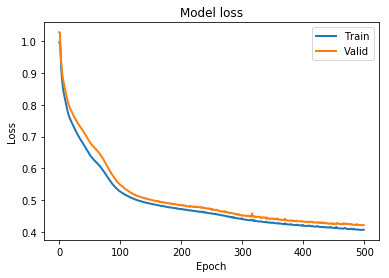

In [25]:
plt.plot(lstm_autoencoder_history['loss'], linewidth=2, label='Train')
plt.plot(lstm_autoencoder_history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

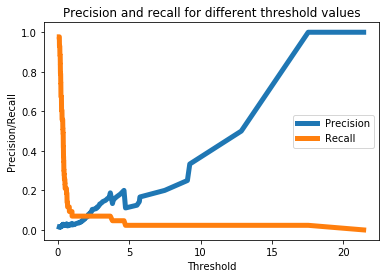

In [26]:
valid_x_predictions = lstm_autoencoder.predict(X_valid_scaled)
mse = np.mean(np.power(flatten(X_valid_scaled) - flatten(valid_x_predictions), 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_valid.tolist()})
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

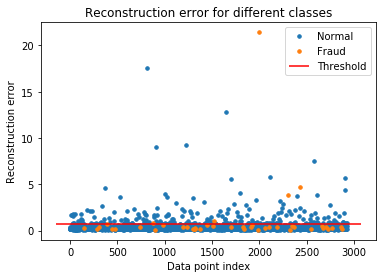

In [27]:
threshold_fixed = 0.7
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

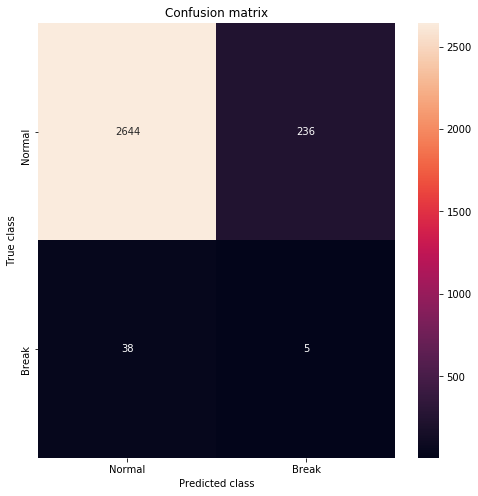

In [34]:
pred_y  = [1 if e> threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [ ]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)
plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)
plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()